In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


In [4]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
embed_size = 10
hidden_size = 300

E = torch.randn((vocab_size, embed_size))
W1 = torch.randn((embed_size*block_size, hidden_size))  * (5/3) / ((embed_size*block_size)**0.5)
W2 = torch.randn((hidden_size, vocab_size)) * 0.1           
b2 = torch.randn(vocab_size) * 0.1    

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain = torch.randn((1, hidden_size)) * 0.1 + 0.1
bnbias = torch.randn((1, hidden_size)) * 0.1
parameters = [E, W1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [6]:
params = sum(p.nelement() for p in parameters)
params

26997

In [7]:
batch_size = 64
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (n, ))
Xb, Yb = Xtr[ix], Ytr[ix]

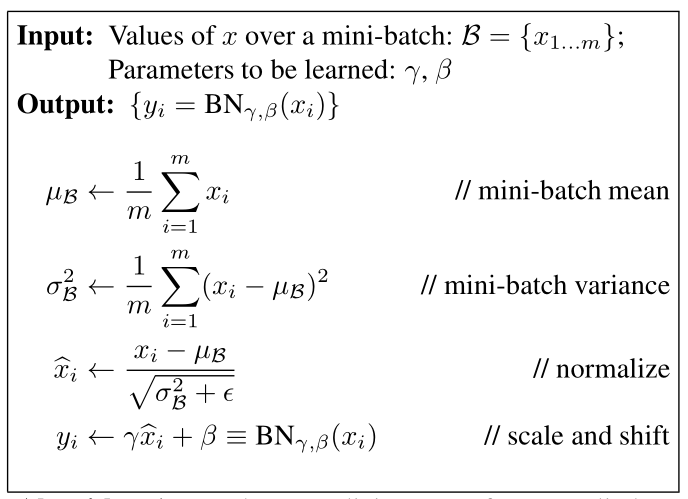

In [8]:
# forward pass 

emb = E[Xb]
print(emb.shape)
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1 # 64 x 300 
print(hprebn.shape)
bnmeani = 1/n * hprebn.sum(0, keepdim=True) 
bndiff = hprebn - bnmeani
bnfidd2 = bndiff**2
bnvar = 1/(n-1) * (bnfidd2).sum(0, keepdim=True)

torch.Size([64, 6, 10])
torch.Size([64, 300])
